In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import itertools
from matplotlib.lines import Line2D
from scipy import linalg
import qinfer
import scipy

import lfig

In [2]:
results_time = 'Jul_28/14_44'
results_time = 'Dec_05/00_00'
results_time = 'Dec_07/22_04'

results_folder = os.path.abspath("/home/bf16951/QMD/scripts/genetic_alg_param_sweep/results/")
results_dir = os.path.join(
    results_folder, 
    results_time
)

results = pd.read_csv(
    os.path.join(results_dir, 'results.csv')
)
results["true_found"] = results["true_found"].astype(int)
results["number_generations"]= results["number_generations"].astype(int)
results["starting_population_size"] = results["starting_population_size"].astype(int)
results["num_protected_elite_models"] = results["num_protected_elite_models"].astype(int)
results["unchanged_elite_num_generations_cutoff"] = results["unchanged_elite_num_generations_cutoff"].astype(int)
results.sort_values(by = ["mutation_probability", "unchanged_elite_num_generations_cutoff"])

configurations = pd.read_csv(os.path.join(results_dir, "configurations.csv"))

In [3]:
mutation_rates = sorted(list(results.mutation_probability.unique()))
elites_preserved = sorted(list(results.num_protected_elite_models.unique()))
elite_generation_cutoff = sorted(list(results.unchanged_elite_num_generations_cutoff.unique()))
elites_preserved = [2] # force only to consider 2
system_sizes = list(results.number_sites.unique())

In [4]:
variables = [mutation_rates, elites_preserved, elite_generation_cutoff]
num_rows = len(variables)
num_cols = max([len(v) for v in variables])

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


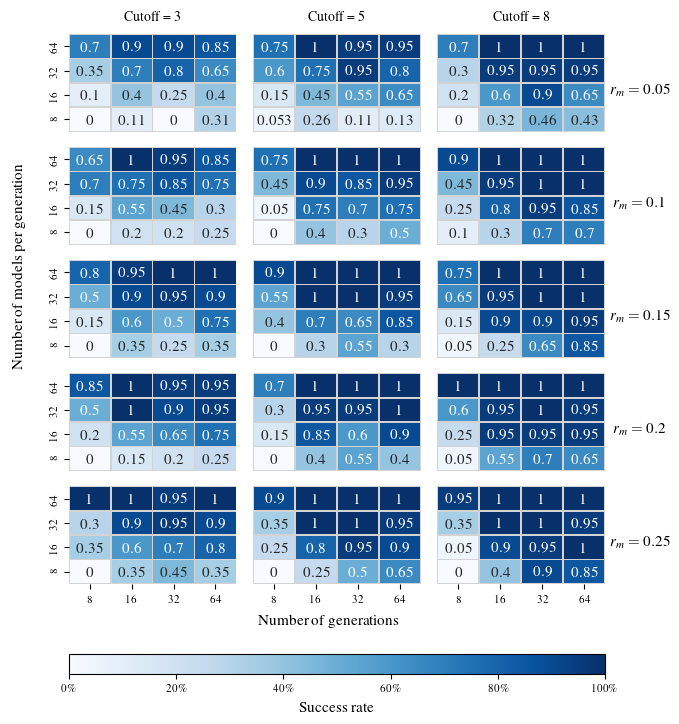

In [8]:
mutation = mutation_rates[0]
num_elites = elites_preserved[0]
num_elite_gen = elite_generation_cutoff[0]
num_sites = system_sizes[0]

ht_ratios = [1,1,1,1,1,0.4,0.2]
lf = lfig.LatexFigure(
    gridspec_layout = (7,3), 
    legend_axis = (6,0),
    legend_span = (1, 'all'),
    gridspec_params = {
        'hspace' : 0.2,
        'wspace' : 0.1,
        'height_ratios' : ht_ratios
    },
    auto_label=False,
#     square_plot = True, 
)
all_records = []


for m in mutation_rates:
    for nge in elite_generation_cutoff:
        for ne in elites_preserved:
            conditions = (
                (results['mutation_probability'] == m) 
                & (results['num_protected_elite_models'] == ne)
                & (results['unchanged_elite_num_generations_cutoff'] == nge)    
                & (results['number_sites'] == 4)    
             )

            results_subset = results[conditions]
            this_subset_piv = pd.pivot_table(
                data = results_subset,
                values="true_found",
                columns=['number_generations'], 
                index = "starting_population_size", 
            )
            this_subset_piv.sort_values(
                by = 'starting_population_size',
                ascending= False, 
                inplace=True
            )
            ax = lf.new_axis(
                auto_label=False
            )
            if ax.row == ax.col == 0 :
                draw_cbar = True
            else:
                draw_cbar = False

            sns.heatmap(
                this_subset_piv, 
                linewidths=.5, 
                linecolor='lightgray',
                cmap=plt.cm.Blues,
                cbar=False, 
                cbar_kws = {
                    "orientation" : "horizontal",
                    "label" : "Success rate"
                },
                cbar_ax = lf.legend_ax, 
                center = 0.5, 
                ax =ax, 
                annot=True, 
            )

            ax.set_ylabel(r"")
            ax.set_xlabel(r"")
            
            if ax.row == 0:
                ax.set_title(
#                     r"$n_{{egc}} = {}$".format(nge),
                    r"Cutoff = {}".format(nge),
                    pad = 10,
                )
            if ax.col == lf.num_cols-1:
                ax.set_ylabel(
                    "$r_m = {}$".format(m),
                    rotation=0,
                    labelpad = 25, 
                )
                ax.yaxis.set_label_position("right")
            
            if ax.row != len(mutation_rates)-1:
                ax.set_xticks([])
            if ax.col != 0:
                ax.set_yticks([])

            description = r"$r_m = {} \ N_{{eg}}={}$".format(m, nge)
            record = {
                "Subplot" : ax.label, 
                r"$r_m$" : m, 
                r"# elites" : ne, 
                r"elite cutoff" : nge, 
            }
            all_records.append(record)

            
# cbar_kws = {
#     "orientation" : "horizontal",
#     "label" : "Success rate"
# },
# lf.legend_ax.cbar()

cbar = mpl.colorbar.ColorbarBase(
    lf.legend_ax, 
    cmap = plt.cm.Blues,
    norm = mpl.colors.Normalize(vmin=0, vmax=1),
    orientation="horizontal",
    label = "Success rate",
    format=mpl.ticker.PercentFormatter(xmax=1)
)
cbar.set_clim(0, 1.0)
            
lf.fig.text(0.5, 0.17, "Number of generations", ha='center')
lf.fig.text(0.04, 0.6, "Number of models per generation", va='center', rotation="vertical")

lf.save(
    os.path.join(results_dir, "heatmaps_annotated.pdf")
)
lf.save(
    os.path.join(
        "/home/bf16951/thesis/theoretical_study/figures",
        "gen_alg_param_sweep_annotated.pdf"
    )
)

In [9]:
import scipy 

In [10]:
scipy.special.comb(6, 2)

15.0

In [25]:
ng = 16
nm = 32
cutoff = 5
rm = 0.2

vals= [8,16,32,64]
for nm in vals:
    for ng in vals:
        for rm in [0.05, 0.1, 0.15, 0.2, 0.25]:
            for cutoff in [3,5,8]:

                this_subset = results[
                    (results.number_generations == ng)
                    & (results.starting_population_size == nm)
                    & (results['mutation_probability'] == rm) 
                    & (results['unchanged_elite_num_generations_cutoff'] == cutoff)    

                ]
                
                n_instances = len(this_subset)
                if n_instances < 20:
                    print("\nCutoff={}  Rm={}  Ng={} Nm={}  ".format(cutoff, rm, ng, nm))
                    print("N instnaces = ", n_instances)
                    print("{} of {} instances".format(
                        this_subset.true_found.mean(),
                        len(this_subset)
                    ))
                    


Cutoff=5  Rm=0.05  Ng=8 Nm=8  
N instnaces =  19
0.05263157894736842 of 19 instances

Cutoff=8  Rm=0.05  Ng=8 Nm=8  
N instnaces =  18
0.0 of 18 instances

Cutoff=3  Rm=0.05  Ng=16 Nm=8  
N instnaces =  19
0.10526315789473684 of 19 instances

Cutoff=5  Rm=0.05  Ng=16 Nm=8  
N instnaces =  19
0.2631578947368421 of 19 instances

Cutoff=8  Rm=0.05  Ng=16 Nm=8  
N instnaces =  19
0.3157894736842105 of 19 instances

Cutoff=3  Rm=0.05  Ng=32 Nm=8  
N instnaces =  17
0.0 of 17 instances

Cutoff=5  Rm=0.05  Ng=32 Nm=8  
N instnaces =  18
0.1111111111111111 of 18 instances

Cutoff=8  Rm=0.05  Ng=32 Nm=8  
N instnaces =  13
0.46153846153846156 of 13 instances

Cutoff=3  Rm=0.05  Ng=64 Nm=8  
N instnaces =  16
0.3125 of 16 instances

Cutoff=5  Rm=0.05  Ng=64 Nm=8  
N instnaces =  15
0.13333333333333333 of 15 instances

Cutoff=8  Rm=0.05  Ng=64 Nm=8  
N instnaces =  14
0.42857142857142855 of 14 instances


20

0.85 of 20 instances


In [6]:
heatmap_df = pd.DataFrame(all_records)
heatmap_df.set_index("Subplot")


table_path=os.path.join(
    results_dir, "heatmaps_descriptions.tex"
)

table = heatmap_df.to_latex(
    buf=None, 
    bold_rows=False,
    float_format="{:0.3g}".format,
    escape=False,
    multirow=True,
#     column_format=col_fmt,
    index_names=True,
    col_space = 40, 
)

table = table.replace("\\toprule", "\\hline")
table = table.replace("\\bottomrule", "\\hline")

with open(table_path, 'w') as f:
    f.write(table)